# 目录
+ 线性回归模型
+ 衡量线性回归模型
+ 岭回归
+ 最优化岭回归的参数
+ LASSO回归
+ 最小角回归 Least-angle regression (LARS)
+ Logistic回归
+ 贝叶斯岭回归
+ 梯度提升回归

In [1]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

# 线性回归模型
LinearRegression类

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
# 准备数据集
from sklearn import datasets
boston = datasets.load_boston()

In [5]:
# 拟合线性回归
lr = LinearRegression()
lr.fit(boston.data, boston.target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
# 预测
predictions = lr.predict(boston.data)

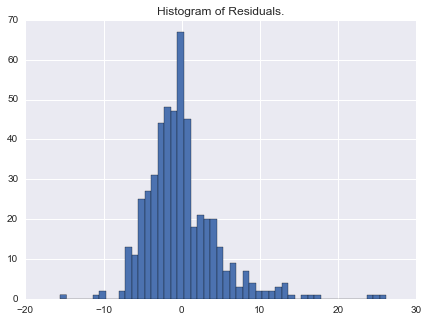

In [7]:
# 残差直方图
import matplotlib.pyplot as plt
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(111)
ax.hist(boston.target - predictions, bins=50)
ax.set_title("Histogram of Residuals.")

In [8]:
# 系数估计值
lr.coef_

array([ -1.07170557e-01,   4.63952195e-02,   2.08602395e-02,
         2.68856140e+00,  -1.77957587e+01,   3.80475246e+00,
         7.51061703e-04,  -1.47575880e+00,   3.05655038e-01,
        -1.23293463e-02,  -9.53463555e-01,   9.39251272e-03,
        -5.25466633e-01])

In [9]:
# 展示特征名和系数估计值
zip(boston.feature_names, lr.coef_)

[('CRIM', -0.10717055656035689),
 ('ZN', 0.046395219529797617),
 ('INDUS', 0.020860239532173769),
 ('CHAS', 2.6885613993179573),
 ('NOX', -17.795758660309158),
 ('RM', 3.8047524602580145),
 ('AGE', 0.00075106170332382217),
 ('DIS', -1.4757587965198196),
 ('RAD', 0.30565503833910118),
 ('TAX', -0.012329346305270586),
 ('PTRATIO', -0.95346355469055821),
 ('B', 0.0093925127221889965),
 ('LSTAT', -0.52546663290078111)]

## 特征标准化

In [10]:
lr2 = LinearRegression(normalize=True)
lr2.fit(boston.data, boston.target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [11]:
predictions2 = lr2.predict(boston.data)

# 衡量线性回归模型

In [12]:
from sklearn import datasets
boston = datasets.load_boston()

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(boston.data, boston.target)
predictions = lr.predict(boston.data)

## 残差直方图

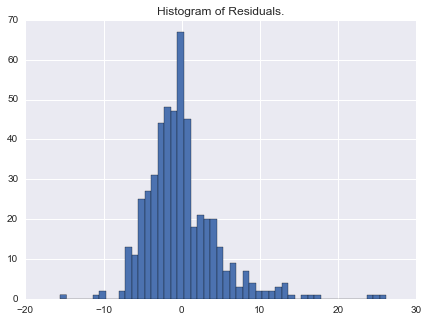

In [13]:
# 残差直方图
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(111)
ax.hist(boston.target - predictions, bins=50) # 残差大致服从均值为0的正态分布
ax.set_title("Histogram of Residuals.");

In [14]:
np.mean(boston.target - predictions) # 残差的均值非常接近0

2.8084693113047438e-15

## Q-Q图

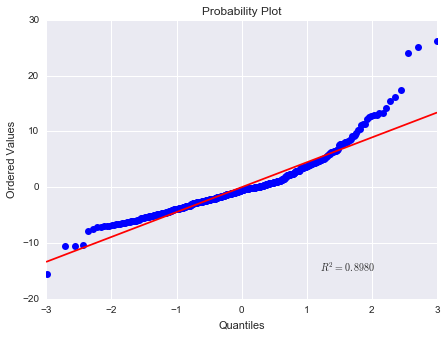

In [15]:
# scipy有绘制Q-Q图的方法，观察残差是否服从正态分布
from scipy.stats import probplot
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(111)
probplot(boston.target - predictions, plot=ax);

# MSE、MAD

In [16]:
# 自定义计算MSE、MAD的函数（后续会介绍sklearn内置的计算方法）
def MSE(target, predictions):
    squared_deviation = np.power(target - predictions, 2)
    return np.mean(squared_deviation)

def MAD(target, predictions):
    absolute_deviation = np.abs(target - predictions)
    return np.mean(absolute_deviation)

In [17]:
MSE(boston.target, predictions), MAD(boston.target, predictions)

(21.8977792176875, 3.2729446379969356)

## bootstrap
不仅仅用于研究参数的分布，还可以用于得到更为精确的参数估计值（重抽样的参数估计量，会更快收敛于参数真实值）

In [18]:
n_bootstraps = 1000
len_boston = len(boston.target)
subsample_size = np.int(0.5*len_boston)
subsample = lambda: np.random.choice(np.arange(0, len_boston), size=subsample_size) # 匿名函数

In [19]:
coefs = np.ones(n_bootstraps)

for i in range(n_bootstraps):
    subsample_idx = subsample() # 技巧：用匿名函数的方式，每次循环都调用一次该函数，达到重抽样的效果
    subsample_X = boston.data[subsample_idx] # 有放回的从原数据集中抽取253个样本（原数据集中有506个样本，有放回抽样，有重复样本）
    subsample_y = boston.target[subsample_idx]
    
    lr.fit(subsample_X, subsample_y)
    
    coefs[i] = lr.coef_[0] # 重抽样1000次，将第一个系数估计值存储于coefs向量中

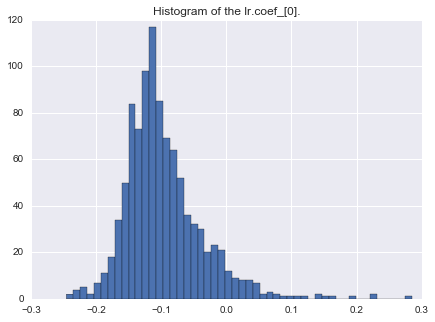

In [20]:
# 参数的估计值大致服从正态分布
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(111)
ax.hist(coefs, bins=50)
ax.set_title("Histogram of the lr.coef_[0].");

In [21]:
np.percentile(coefs, [2.5, 97.5]) # 重抽样的置信区间；0在置信区间内，该参数可能不显著

array([-0.18717257,  0.04266147])

# 岭回归
Ridge类

In [22]:
from sklearn.linear_model import LinearRegression, Ridge

In [23]:
# 创建不满秩数据集
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=2000, n_features=3, effective_rank=2, noise=10)

# 普通回归

In [24]:
lr = LinearRegression()

In [25]:
n_bootstraps = 1000
len_data = len(reg_data)
subsample_size = np.int(0.75*len_data)
subsample = lambda: np.random.choice(np.arange(0, len_data), size=subsample_size)

coefs = np.ones((n_bootstraps, 3))

for i in range(n_bootstraps):
    subsample_idx = subsample()
    subsample_X = reg_data[subsample_idx]
    subsample_y = reg_target[subsample_idx]
    
    lr.fit(subsample_X, subsample_y)
    
    coefs[i][0] = lr.coef_[0]
    coefs[i][1] = lr.coef_[1]
    coefs[i][2] = lr.coef_[2]

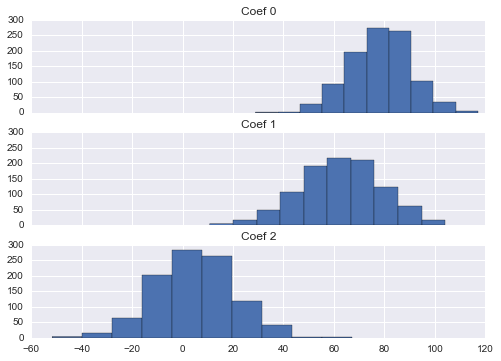

In [26]:
# 绘制参数估计值的分布直方图
f, axes = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(7, 5))
f.tight_layout()

for i, ax in enumerate(axes):
    ax.hist(coefs[:, i])
    ax.set_title("Coef {}".format(i));

## 岭回归

In [27]:
r = Ridge()

In [28]:
n_bootstraps = 1000
len_data = len(reg_data)
subsample_size = np.int(0.75*len_data)
subsample = lambda: np.random.choice(np.arange(0, len_data), size=subsample_size)

coefs_r = np.ones((n_bootstraps, 3))

for i in range(n_bootstraps):
    subsample_idx = subsample()
    subsample_X = reg_data[subsample_idx]
    subsample_y = reg_target[subsample_idx]
    
    r.fit(subsample_X, subsample_y)
    
    coefs_r[i][0] = r.coef_[0]
    coefs_r[i][1] = r.coef_[1]
    coefs_r[i][2] = r.coef_[2]

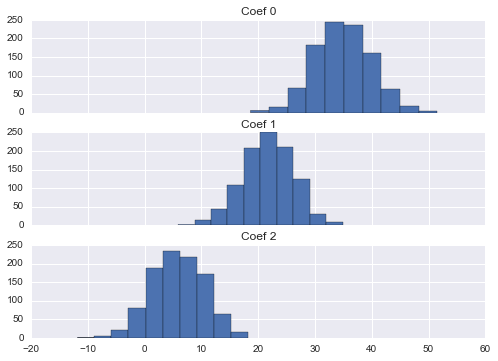

In [29]:
f, axes = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(7, 5))
f.tight_layout()

for i, ax in enumerate(axes):
    ax.hist(coefs_r[:, i])
    ax.set_title("Coef {}".format(i))

In [30]:
np.mean(coefs, axis=0), np.mean(coefs_r, axis=0) # 岭回归的参数估计量，均值更接近于0

(array([ 78.29868467,  62.78975608,   4.50688658]),
 array([ 34.98343556,  21.74119876,   5.83352552]))

In [31]:
np.var(coefs, axis=0), np.var(coefs_r, axis=0) # 岭回归的参数估计量，方差更小（bias-variance trade-off，参数估计量有偏，换来参数估计量方差更小）

(array([ 142.91559192,  252.69330884,  246.73310343]),
 array([ 24.53257198,  19.93082125,  20.65124529]))

Linear Regression works, but finding the vector of Betas that minimizes

$$\|\hat{y} - X\beta\|^2$$

Ridge Regression fins the vector of Betas that minimizes

$$\|\hat{y} - X\beta\|^2 + \|\Gamma X\|^2$$

Where $\Gamma$ is typically $\alpha I$, or some scaler times the identity matrix.

This minimization has the solution

$$ \beta = (X^T X + \Gamma^T \Gamma)^{-1} X y $$

In [32]:
r # 查看Ridge类的参数设置，尤其是alpha值

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

# 最优化岭回归的参数
RidgeCV类

In [33]:
from sklearn.linear_model import RidgeCV

In [34]:
# 创建不满秩数据集
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=100, n_features=2, effective_rank=1, noise=10)

In [35]:
rcv = RidgeCV(alphas=np.array([.1, .2, .3, .4]))
rcv.fit(reg_data, reg_target)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [36]:
rcv.alpha_ # 模型训练好后，可以返回最优化的alpha参数

0.10000000000000001

In [37]:
rcv2 = RidgeCV(alphas=np.array([.08, .09, .1, .11, .12])) # 在0.1附近继续调优参数
rcv2.fit(reg_data, reg_target)

RidgeCV(alphas=array([ 0.08,  0.09,  0.1 ,  0.11,  0.12]), cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [38]:
rcv2.alpha_ # 参数进一步优化至0.08

0.080000000000000002

## 绘制MSE-vs-alpha的图

In [39]:
alphas_to_test = np.linspace(0.01, 1) # 从0.01到1之间均匀取50个数
rcv3 = RidgeCV(alphas=alphas_to_test, store_cv_values=True) # 设置store_cv_values=True，将会存储交叉验证模型误差
rcv3.fit(reg_data, reg_target)

RidgeCV(alphas=array([ 0.01   ,  0.0302 ,  0.05041,  0.07061,  0.09082,  0.11102,
        0.13122,  0.15143,  0.17163,  0.19184,  0.21204,  0.23224,
        0.25245,  0.27265,  0.29286,  0.31306,  0.33327,  0.35347,
        0.37367,  0.39388,  0.41408,  0.43429,  0.45449,  0.47469,
        0.4949 ,  0.5151 ...3837,
        0.85857,  0.87878,  0.89898,  0.91918,  0.93939,  0.95959,
        0.9798 ,  1.     ]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [40]:
rcv3.cv_values_.shape # 测试50个参数，在每个参数下，模型训练了100次

(100L, 50L)

In [41]:
smallest_idx = rcv3.cv_values_.mean(axis=0).argmin()
alphas_to_test[smallest_idx] # 通过cv_values_矩阵，算出最优化的alpha

0.01

In [42]:
rcv3.alpha_ # alpha_属性返回的最优化alpha，与cv_values_矩阵算出的最优化alpha一致

0.01

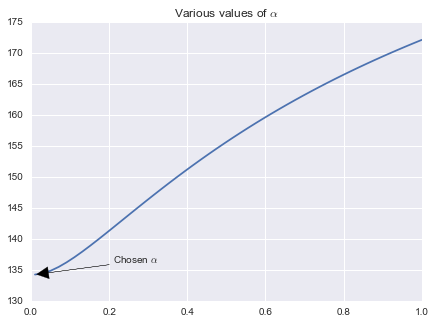

In [43]:
f, ax = plt.subplots(figsize=(7, 5))
ax.set_title(r"Various values of $\alpha$")

xy = (alphas_to_test[smallest_idx], rcv3.cv_values_.mean(axis=0)[smallest_idx])
xytext = (xy[0] + .2, xy[1] + 2)

ax.annotate(r'Chosen $\alpha$', xy=xy, xytext=xytext,
            arrowprops=dict(facecolor='black', shrink=0.02, width=.02)
            )

ax.plot(alphas_to_test, rcv3.cv_values_.mean(axis=0));

## 自定义最优化目标函数（loss function）
metrics.make_scorer方法

In [44]:
# 定义MAD函数（取代MSE）
def MAD(target, predictions):
    absolute_deviation = np.abs(target - predictions)
    return absolute_deviation.mean()

In [45]:
import sklearn
MAD = sklearn.metrics.make_scorer(MAD, greater_is_better=False) # 这里MAD是损失函数而非得分函数，所以要最小化loss function，设置greater_is_better=False

In [46]:
rcv4 = RidgeCV(alphas=alphas_to_test, store_cv_values=True, scoring=MAD)
rcv4.fit(reg_data, reg_target)

RidgeCV(alphas=array([ 0.01   ,  0.0302 ,  0.05041,  0.07061,  0.09082,  0.11102,
        0.13122,  0.15143,  0.17163,  0.19184,  0.21204,  0.23224,
        0.25245,  0.27265,  0.29286,  0.31306,  0.33327,  0.35347,
        0.37367,  0.39388,  0.41408,  0.43429,  0.45449,  0.47469,
        0.4949 ,  0.5151 ...3837,
        0.85857,  0.87878,  0.89898,  0.91918,  0.93939,  0.95959,
        0.9798 ,  1.     ]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=make_scorer(MAD, greater_is_better=False),
    store_cv_values=True)

In [47]:
smallest_idx = rcv4.cv_values_.mean(axis=0).argmin()
alphas_to_test[smallest_idx] # 找出最优化的alpha参数

0.29285714285714287

In [48]:
rcv4.alpha_ # alpha_属性返回的最优化alpha值与上面求出的不同，为什么？

0.030204081632653063

# LASSO回归
Lasso类

In [49]:
from sklearn.linear_model import Lasso

In [50]:
# 创建不满秩数据集
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=200, n_features=500, n_informative=5, noise=5)

In [51]:
lasso = Lasso()
lasso.fit(reg_data, reg_target) # alpha参数默认值为1

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [52]:
np.sum(lasso.coef_ != 0) # 返回选择留下的特征个数

11

In [53]:
lasso_0 = Lasso(0) # 当LASSO回归中alpha参数设为0，效果与普通线性回归相同
lasso_0.fit(reg_data, reg_target)
np.sum(lasso_0.coef_ != 0)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from ipykernel import kernelapp as app
C:\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)


500

## 最优化LASSO回归的参数
LassoCV类

In [54]:
from sklearn.linear_model import LassoCV

In [55]:
lassocv = LassoCV()
lassocv.fit(reg_data, reg_target)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [56]:
lassocv.alpha_ # 返回最优化的alpha参数

0.75968897033436444

In [57]:
lassocv.coef_[:5] # 返回参数估计值

array([-0., -0., -0., -0.,  0.])

In [58]:
np.sum(lassocv.coef_ != 0) # 返回选择留下的特征个数

18

## 特征选择

In [59]:
mask = lassocv.coef_ != 0
new_reg_data = reg_data[:, mask]
new_reg_data.shape # 只保留被选择留下的特征

(200L, 18L)

# 最小角回归 Least-angle regression (LARS)
Lars类  
应用于高维问题

In [60]:
from sklearn.linear_model import Lars

In [61]:
# 创建不满秩数据集
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=200, n_features=500, n_informative=10, noise=2)

In [62]:
lars = Lars(n_nonzero_coefs=10) # 由于模拟数据集中有10个有意义的特征，所以这里设置保留10个非零特征
lars.fit(reg_data, reg_target)

Lars(copy_X=True, eps=2.2204460492503131e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=10, normalize=True, positive=False,
   precompute='auto', verbose=False)

In [63]:
np.sum(lars.coef_ != 0) # 确实保留了10个非零特征

10

## 通过LARS做特征选择的意义

In [64]:
train_n = 100 # 前100个样本做训练集
lars_12 = Lars(n_nonzero_coefs=12) # 训练LARS模型，保留12个非零特征（我们并不总是能够准确知道，究竟有多少个有意义的特征）
lars_12.fit(reg_data[:train_n], reg_target[:train_n])

lars_500 = Lars() # 不做特征选择，500个特征全部被保留
lars_500.fit(reg_data[:train_n], reg_target[:train_n]);

C:\Anaconda2\lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 127 iterations, i.e. alpha=3.096e-02, with an active set of 100 regressors, and the smallest cholesky pivot element being 9.996e-08
  ConvergenceWarning)


In [65]:
np.mean(np.power(reg_target[train_n:] - lars_12.predict(reg_data[train_n:]), 2)) # 在测试集上观察模型表现

11.172524401073435

In [66]:
np.mean(np.power(reg_target[train_n:] - lars_500.predict(reg_data[train_n:]), 2)) # 不做特征选择，在测试集上出现严重的过拟合问题

8.2486290592312924e+30

## LARS的工作原理

LARS works be interively choosing features which are correlated with the residuals.  Geometically correlation is effectively the least angle between the feature and the residuals, this is how LARs gets its name.

After choosing the first feature, LARS will continue to move in the least angle direction until a different feature has the same amount of correlation with the residuals.  Then LARS will begin to move in the combined direction of both features.  To visualize this, consider the following graph.

In [67]:
def unit(*args):
    squared = map(lambda x: x**2, args)
    distance = sum(squared) ** (.5)
    return map(lambda x: x / distance, args)

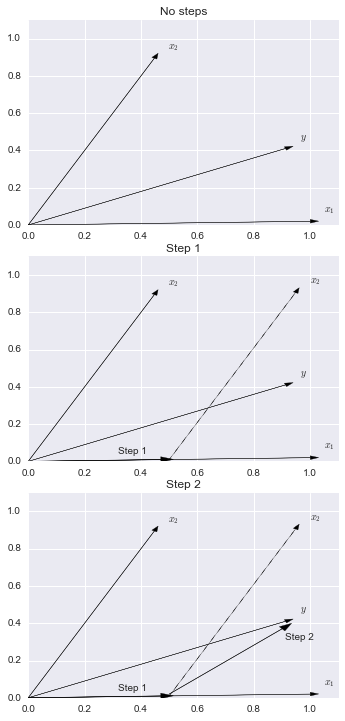

In [68]:
f, ax = plt.subplots(nrows=3, figsize=(5, 10))
#ax[0].axis('off')
plt.tight_layout()
ax[0].set_ylim(0, 1.1)
ax[0].set_xlim(0, 1.1)

x, y = unit(1, 0.02)
ax[0].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[0].text(x + .05, y + .05, r"$x_1$")

x, y = unit(.5, 1)
ax[0].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[0].text(x + .05, y + .05, r"$x_2$")

x, y = unit(1, .45)
ax[0].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[0].text(x + .05, y + .05, r"$y$")

ax[0].set_title("No steps")

#step 1
ax[1].set_title("Step 1")
ax[1].set_ylim(0, 1.1)
ax[1].set_xlim(0, 1.1)

x, y = unit(1, 0.02)
ax[1].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[1].text(x + .05, y + .05, r"$x_1$")

x, y = unit(.5, 1)
ax[1].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[1].text(x + .05, y + .05, r"$x_2$")

x, y = unit(.5, 1)
ax[1].arrow(.5, 0.01, x, y, ls='dashed', edgecolor='black', facecolor='black')
ax[1].text(x + .5 + .05, y + .01 + .05, r"$x_2$")

ax[1].arrow(0, 0, .47, .01, width=.0015, edgecolor='black', facecolor='black')
ax[1].text(.47-.15, .01 + .03, "Step 1")

x, y = unit(1, .45)
ax[1].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[1].text(x + .05, y + .05, r"$y$")

#step 2
ax[2].set_title("Step 2")
ax[2].set_ylim(0, 1.1)
ax[2].set_xlim(0, 1.1)

x, y = unit(1, 0.02)
ax[2].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[2].text(x + .05, y + .05, r"$x_1$")

x, y = unit(.5, 1)
ax[2].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[2].text(x + .05, y + .05, r"$x_2$")

x, y = unit(.5, 1)
ax[2].arrow(.5, 0.01, x, y, ls='dashed', edgecolor='black', facecolor='black')
ax[2].text(x + .5 + .05, y + .01 + .05, r"$x_2$")

ax[2].arrow(0, 0, .47, .01, width=.0015, edgecolor='black', facecolor='black')
ax[2].text(.47-.15, .01 + .03, "Step 1")

## step 2
x, y = unit(1, .45)
ax[2].arrow(.5, .02, .4, .35, width=.0015, edgecolor='black', facecolor='black')
ax[2].text(x, y - .1, "Step 2")

x, y = unit(1, .45)
ax[2].arrow(0, 0, x, y, edgecolor='black', facecolor='black')
ax[2].text(x + .05, y + .05, r"$y$")

So we're moving along $x_1$ until we get to the point where the "pull" on $x_1$ by $y$ is the same as the "pull" on $x_2$ by $y$.  When this occurs we'll move along the path which is equal to the angle between $x_1$ and $x_2$ divided by 2.

## 最优化LARS回归的参数
LarsCV类

In [69]:
from sklearn.linear_model import LarsCV

In [70]:
lcv = LarsCV()
lcv.fit(reg_data, reg_target)

LarsCV(copy_X=True, cv=None, eps=2.2204460492503131e-16, fit_intercept=True,
    max_iter=500, max_n_alphas=1000, n_jobs=1, normalize=True,
    positive=False, precompute='auto', verbose=False)

In [71]:
np.sum(lcv.coef_ != 0) # 返回选择留下的特征个数

30

# Logistic回归
LogisticRegression类

In [72]:
from sklearn.linear_model import LogisticRegression

In [73]:
# 创建分类问题数据集
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4)

In [74]:
# 取最后200个样本为测试集
X_train = X[:-200]
X_test = X[-200:]
y_train = y[:-200]
y_test = y[-200:]

In [75]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_train_predictions = lr.predict(X_train) # 对训练集和测试集都进行预测，比较两者的预测误差
y_test_predictions = lr.predict(X_test)

In [76]:
(y_train_predictions == y_train).sum().astype(float) / y_train.shape[0] # 训练集上的正确率

0.88875000000000004

In [77]:
(y_test_predictions == y_test).sum().astype(float) / y_test.shape[0] # 测试集上的正确率

0.91000000000000003

## 类别不平衡问题

In [78]:
# 创建类别不平衡的分类数据集
X, y = make_classification(n_samples=5000, n_features=4, weights=[.95])

In [79]:
sum(y) / (len(y)*1.) # 确保负例只占5%

0.054800000000000001

In [80]:
# 取出后500个样本为测试集
X_train = X[:-500]
X_test = X[-500:]
y_train = y[:-500]
y_test = y[-500:]

In [81]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_train_predictions = lr.predict(X_train) # 对训练集和测试集都进行预测，比较两者的预测误差
y_test_predictions = lr.predict(X_test)

In [82]:
(y_train_predictions == y_train).sum().astype(float) / y_train.shape[0] # 训练集上的正确率

0.95533333333333337

In [83]:
(y_test_predictions == y_test).sum().astype(float) / y_test.shape[0] # 测试集上的正确率

0.95399999999999996

In [84]:
(y_test_predictions[y_test==1]).sum().astype(float) / y_test[y_test==1].shape[0] # 实际上召回率很低，预测效果很差

0.18181818181818182

In [85]:
lr = LogisticRegression(class_weight={0: .15, 1: .85}) # 0类比例为0.05，设置0:0.15，对0类过采样
lr.fit(X_train, y_train)
y_train_predictions = lr.predict(X_train)
y_test_predictions = lr.predict(X_test)

In [86]:
(y_test_predictions[y_test==1]).sum().astype(float) / y_test[y_test==1].shape[0] # 召回率显著提高

0.72727272727272729

In [87]:
(y_test_predictions == y_test).sum().astype(float) / y_test.shape[0] # 代价是正确率下降

0.92600000000000005

# 贝叶斯岭回归
BayesianRidge类

In [88]:
from sklearn.linear_model import BayesianRidge

In [89]:
# 创建数据集
from sklearn.datasets import make_regression
X, y = make_regression(1000, 10, n_informative=2, noise=20)

In [90]:
br = BayesianRidge()
br.fit(X, y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [91]:
br.coef_

array([  0.12231023,   0.40569002,  47.32366162,   0.04735974,
         0.94693945,  -0.26314118,  18.34399602,  -1.01022237,
         0.15905281,   1.61021624])

In [92]:
br_alphas = BayesianRidge(alpha_1=10, lambda_1=10) # 调整参数
br_alphas.fit(X, y)

BayesianRidge(alpha_1=10, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=10, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [93]:
br_alphas.coef_

array([  0.12100305,   0.40463465,  47.18316339,   0.04757591,
         0.94311919,  -0.25894404,  18.28210458,  -1.01124239,
         0.16231068,   1.60367339])

# 梯度提升回归
GradientBoostingRegressor类

In [94]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [95]:
from sklearn.datasets import make_regression
X, y = make_regression(1000, 2, noise=10)

In [96]:
# 先建一个普通线性回归模型作对照
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)
lr_preds = lr.predict(X)

In [97]:
gbr = GBR()
gbr.fit(X, y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [98]:
gbr_preds = gbr.predict(X)

In [99]:
gbr_residuals = y - gbr_preds # 梯度提升回归的残差
lr_residuals = y - lr_preds # 普通线性回归的残差

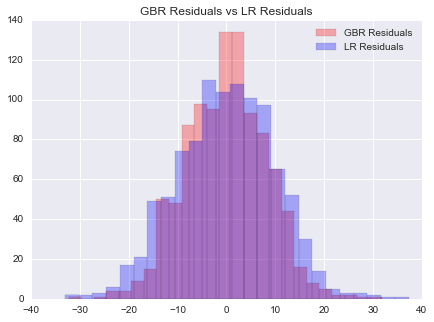

In [100]:
# 梯度提升回归与普通线性回归残差的对照
f, ax = plt.subplots(figsize=(7, 5))
ax.hist(gbr_residuals, bins=25, alpha=.3, label='GBR Residuals', color='r')
ax.hist(lr_residuals, bins=25, alpha=.3, label='LR Residuals', color='b')
ax.set_title("GBR Residuals vs LR Residuals")
ax.legend();

In [101]:
np.percentile(gbr_residuals, [2.5, 97.5]) # 梯度提升回归残差的置信区间

array([-15.33167709,  15.46092775])

In [102]:
np.percentile(lr_residuals, [2.5, 97.5]) # 普通线性回归残差的置信区间

array([-20.21128941,  18.64471549])

## 参数

### max_depth
max_depth: Controls how many nodes are produced for the trees.

### loss
loss: Determines the error.
+ 'ls': least squares regression.
+ 'lad': least absolute deviation. A highly robust loss function solely based on order information of the input variables.
+ 'huber': A combination of the two.
+ 'quantile': Allows quantile regression (use alpha to specify the quantile).

### n_estimators
n_estimators: The number of weak learners that are used in GBR.

In [103]:
n_estimators = np.arange(100, 1100, 350)
gbrs = [GBR(n_estimators=n_estimator) for n_estimator in n_estimators]

In [104]:
residuals = {}

for i, gbr in enumerate(gbrs):
    gbr.fit(X, y)
    residuals[gbr.n_estimators] = y - gbr.predict(X)

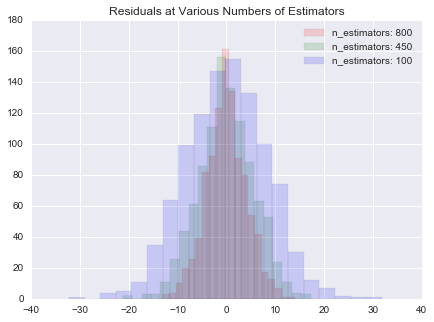

In [105]:
f, ax = plt.subplots(figsize=(7, 5))
colors = ['r', 'g', 'b']

for i, (k, v) in enumerate(residuals.iteritems()):
    ax.hist(v, bins=20, color=colors[i], alpha=.15, label='n_estimators: {}'.format(k))
    
ax.legend()
ax.set_title("Residuals at Various Numbers of Estimators");